In [1]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [2]:
large_noise_wave = WaveGen(size=100).linear_phase().cos().amp(.5).t_noise(std=.01, dof=5).sample(1).samples.squeeze()
small_noise_wave = WaveGen(size=100).linear_phase().cos().amp(.5).t_noise(std=.05, dof=5).sample(1).samples.squeeze()
noise_wave = np.r_[large_noise_wave, small_noise_wave]

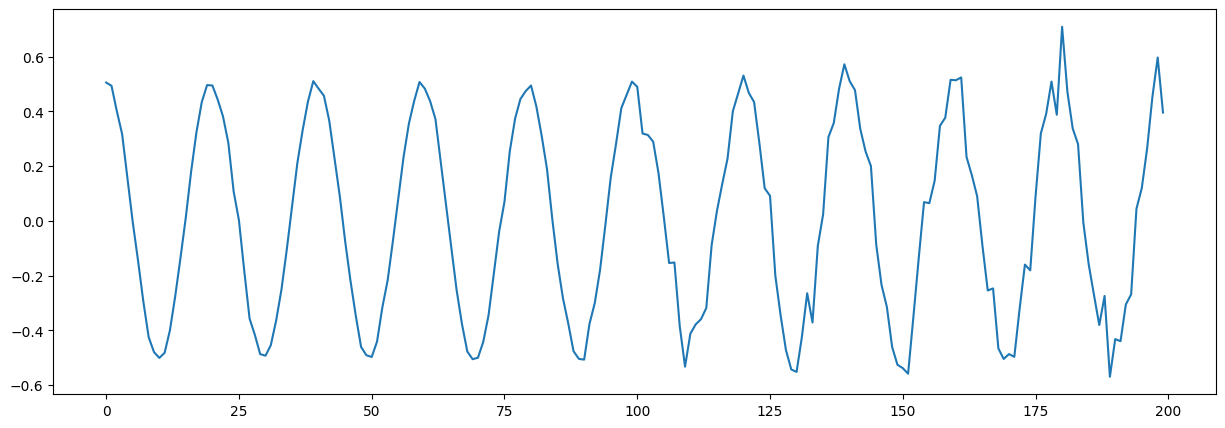

In [3]:
plt.figure(figsize=(15,5))
plt.plot(noise_wave)
plt.show()

In [4]:
class SineBinarySeparator(nn.Module):
    def __init__(self, input_dim=2000, output_dim=2000, dropout_p=.5, eps=1e-4):
        super(SineBinarySeparator, self).__init__()
        self.eps = eps
        self.input = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()
        self.hidden = nn.Linear(output_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_p)
        self.hidden2 = nn.Linear(output_dim, input_dim)
        return
        
    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.hidden(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        hyperbolic_x = torch.tanh(x)
        return hyperbolic_x

    def var_loss(self, hyperbolic_x, x):
        hyper_detach = hyperbolic_x.detach()
        x_detach = x.detach()
        zero_up = torch.where(hyperbolic_x < 0, 1, 0)
        zero_down = torch.where(hyperbolic_x >= 0, 1, 0)
        up_count = torch.count_nonzero(zero_up) - 1 # not exactly bessels correction, discourages variance going to 0
        down_count = torch.count_nonzero(zero_down) - 1
        x = x - x.mean()
        x = torch.square(x)
        up_x = x * zero_up
        var_up = up_x.sum() / up_count
        down_x = x * zero_down
        var_down = down_x.sum() / down_count
        
        return torch.log(1 / (var_up - var_down + self.eps)).unsqueeze(0)
        
    def mean_loss(self, hyperbolic_x, x):
        hyper_detach = hyperbolic_x.detach()
        x_detach = x.detach()
#         zero_tensor = torch.zeros_like(hyperbolic_x)
        zero_up = torch.where(hyperbolic_x < 0, 1, 0)
        zero_down = torch.where(hyperbolic_x >= 0, 1, 0)
        up_count = torch.count_nonzero(zero_up)
        down_count = torch.count_nonzero(zero_down)
        mean_up = x[zero_up].mean()
        mean_down = x[zero_down].mean()
        return torch.log(1 / (mean_up - mean_down + self.eps)).unsqueeze(0)
    
    def configure_optimizer(self, **kwargs):
        optimizer = torch.optim.RMSprop(self.parameters(), **kwargs)
        return optimizer
    
    def train(self, x, epochs=1000, batch_size=128, metric='variance', noise_dist='gaussian', noise_std=.05):
        if not hasattr(self, 'loss_items'):
            self.loss_items = list()
        else:
            self.loss_items.clear()
        optimizer = self.configure_optimizer()
        criterion = nn.MSELoss()
        for epoch in range(epochs // batch_size):
            losses = list()
            optimizer.zero_grad()
            for _ in range(batch_size):
                if noise_dist == 'constant':
                    noise = torch.randn(1) * noise_std
                elif noise_dist == 'gaussian':
                    noise = torch.randn(x.shape[0]) * noise_std         
                elif noise_dist is not None:
                    raise ValueError('Invalid noise identifier')
                    
                forward_x = x + noise
                hyperbolic_x = self.forward(forward_x)
                
                if metric == 'variance':
                    loss = self.var_loss(hyperbolic_x, forward_x)
                elif metric == 'mean':
                    loss = self.mean_loss(hyperbolic_x, forward_x)
                elif metric == 'jsd':
                    loss = self.jsd_loss(hyperbolic_x, forward_x)
                else:
                    raise ValueError('Invalid metric identifier')
                losses.append(loss)
            loss = torch.cat(losses, dim=0)
            self.loss_items.extend(loss.tolist())

            loss.mean().backward()
            optimizer.step()
        self.plot_output(hyperbolic_x, x)
        return
            
    def plot_loss(self, step=1, title=''):
        plt.figure(figsize=(16,8))
        sns.lineplot(self.loss_items[::step], dashes=False, label='Variance Difference Loss')
        plt.title(title)
        plt.legend()
        plt.show()
        return
    
    def plot_output(self, hyperbolic_x, x):
        hyperbolic_x = hyperbolic_x.detach().numpy()
        x = x.detach().numpy()
        up_mask = hyperbolic_x >= 0
        down_mask = hyperbolic_x < 0

        fig, ax = plt.subplots(figsize=(15,5))
        horizontal = np.linspace(0, len(hyperbolic_x) - 1, len(hyperbolic_x)).astype(np.int32)
        assert horizontal.shape == x.shape
        up_indices = horizontal[up_mask]
        down_indices = horizontal[down_mask]
        
        ax.hist(x[up_indices], color='orange', alpha=.4)
        ax.hist(x[down_indices], color='purple', alpha=.4)
        plt.show()
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(15,5))
        ax1.scatter(up_indices, x[up_indices], label='A')
        ax2.scatter(down_indices, x[down_indices], label='B')
        ax1.legend()
        ax2.legend()
        plt.show()
        return

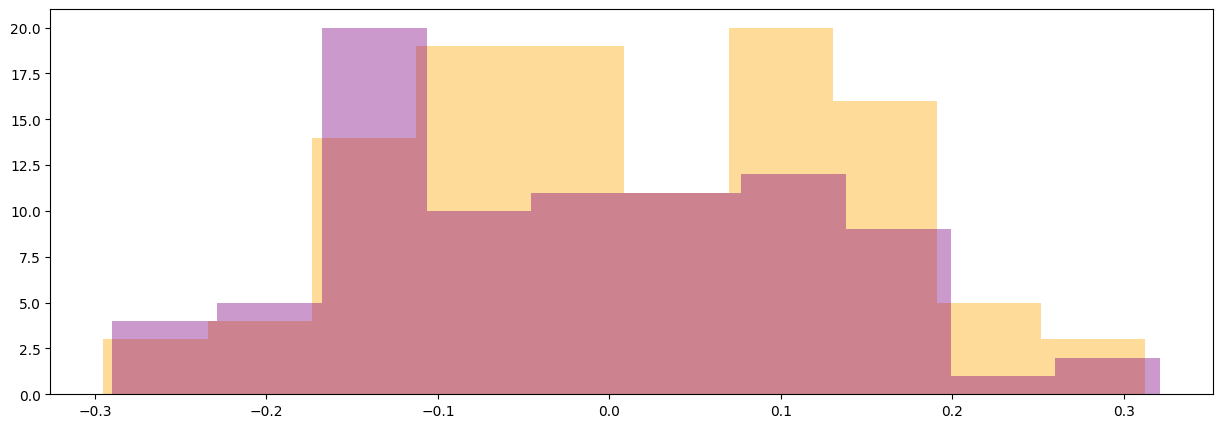

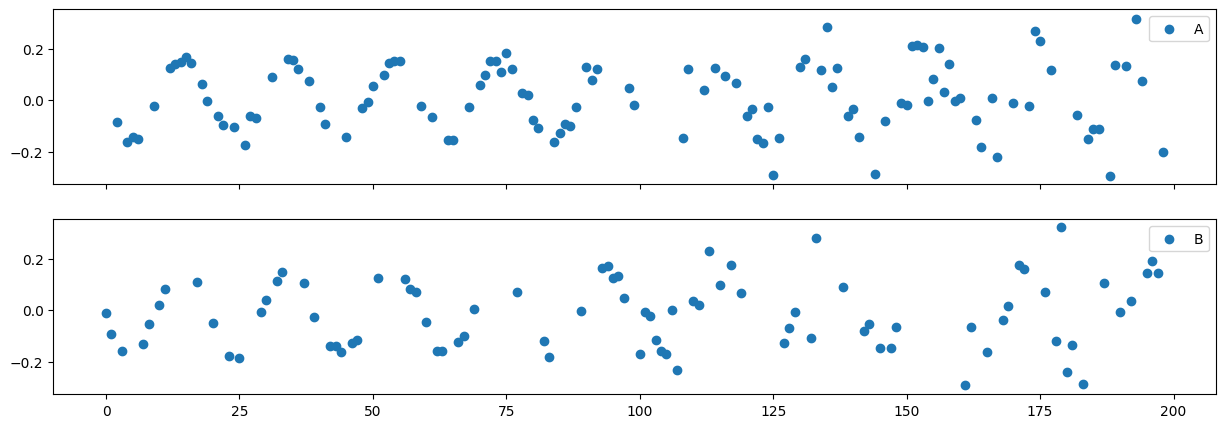

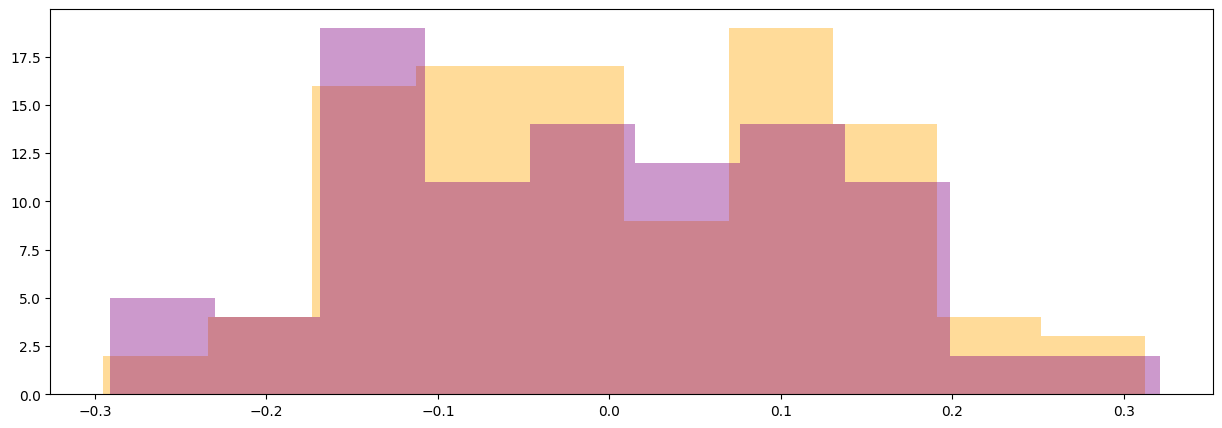

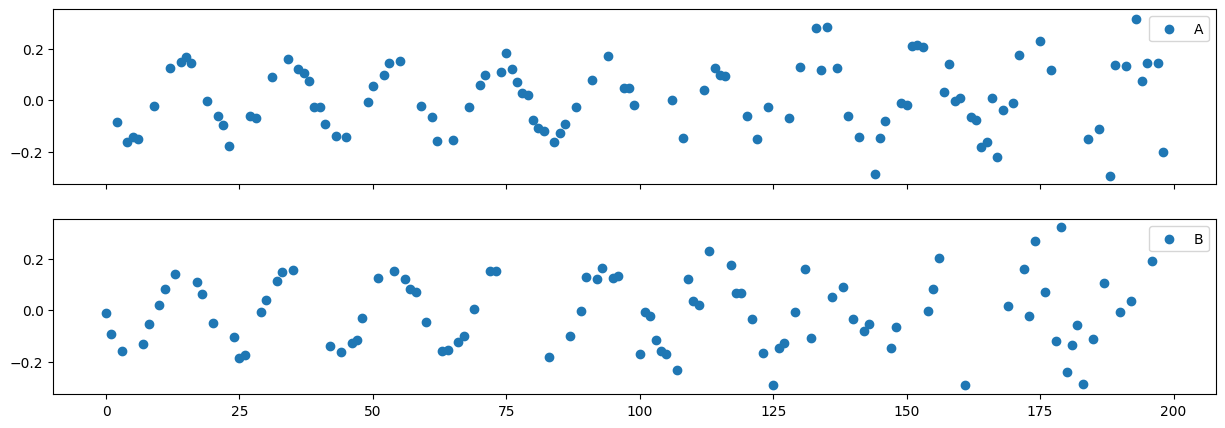

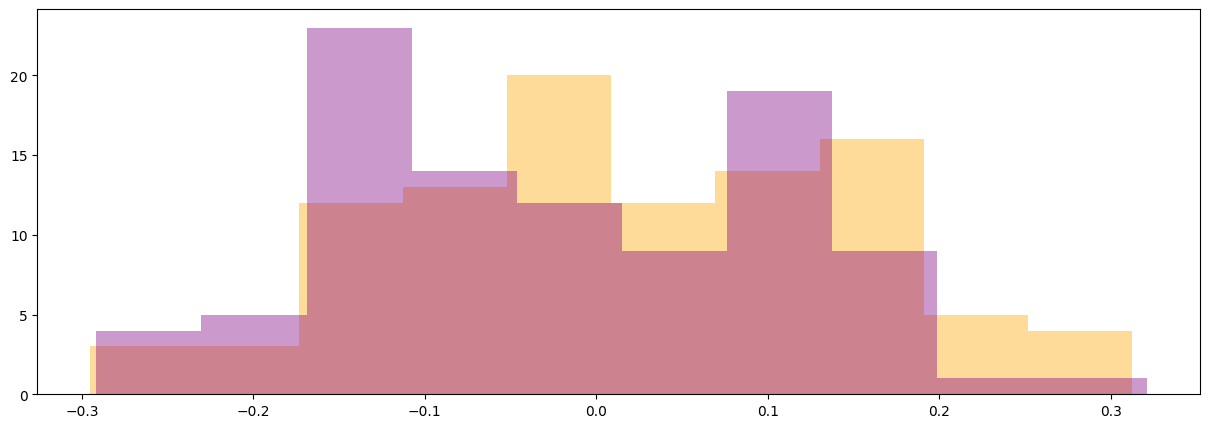

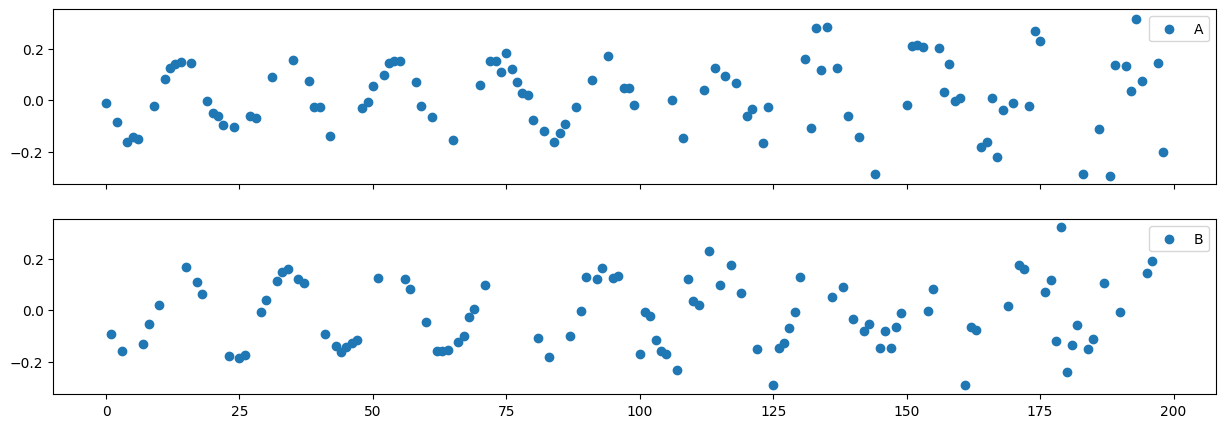

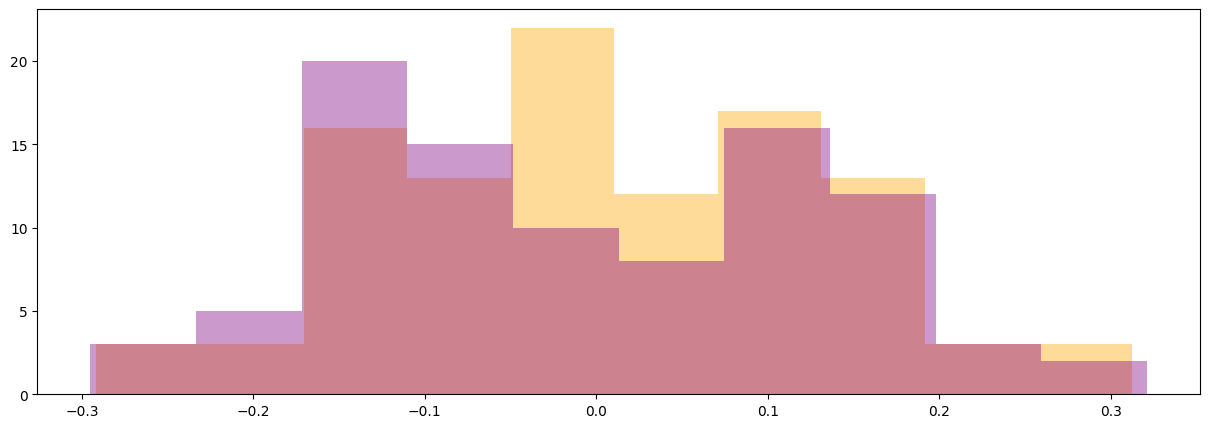

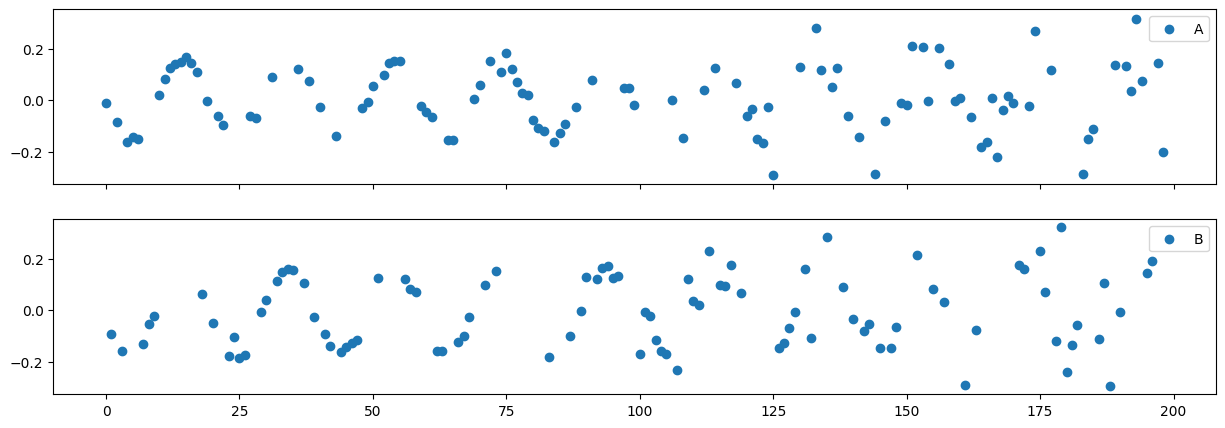

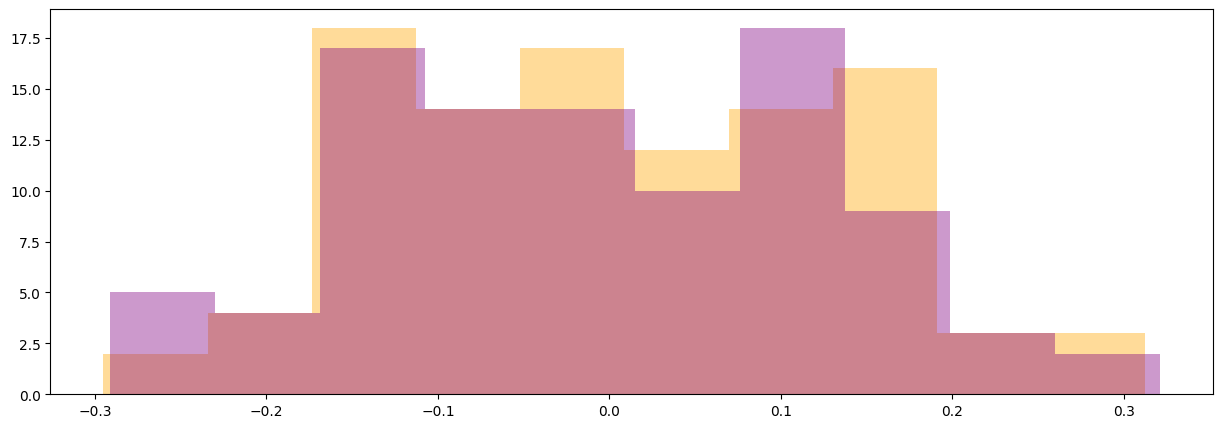

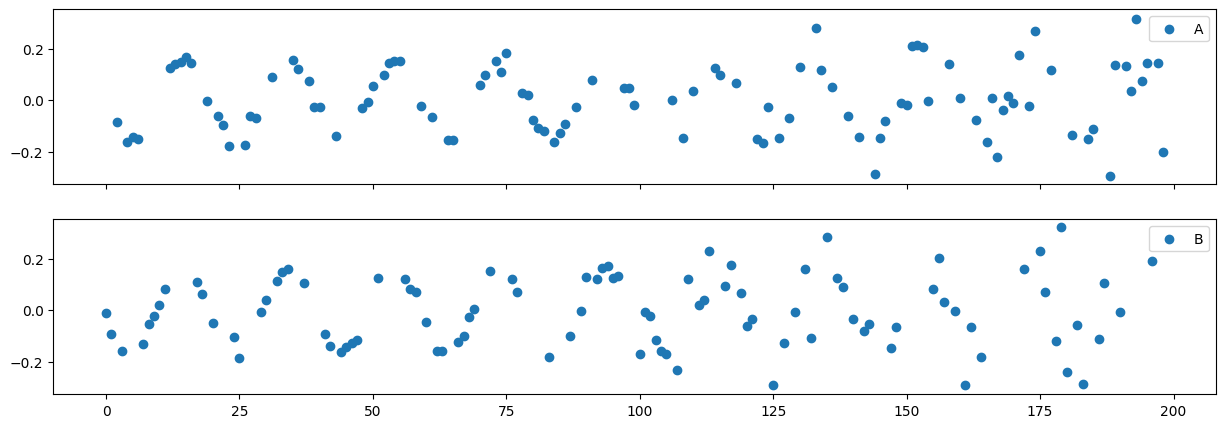

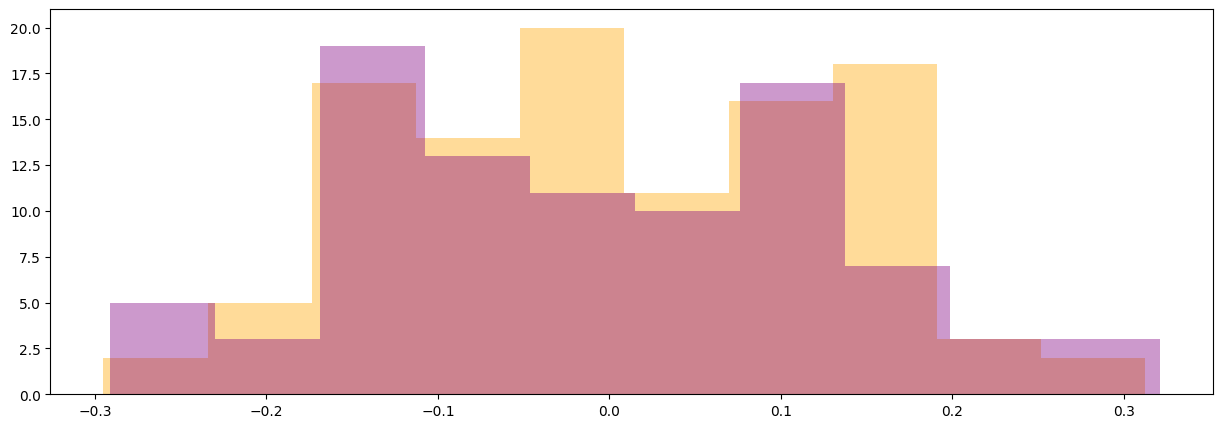

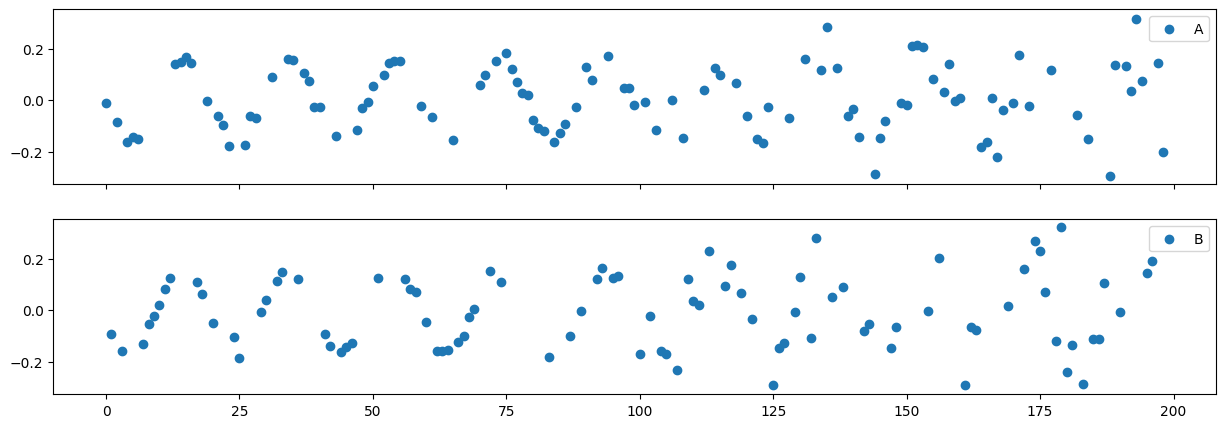

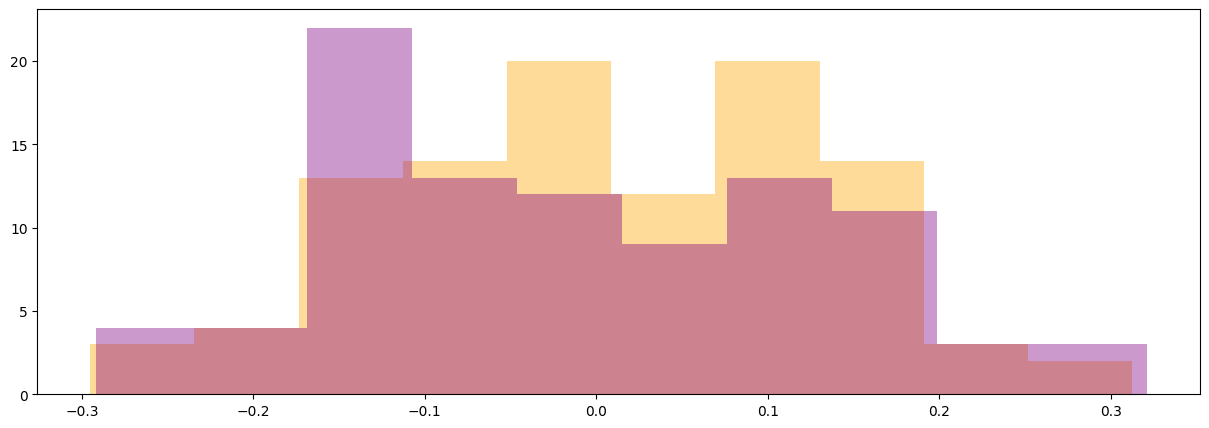

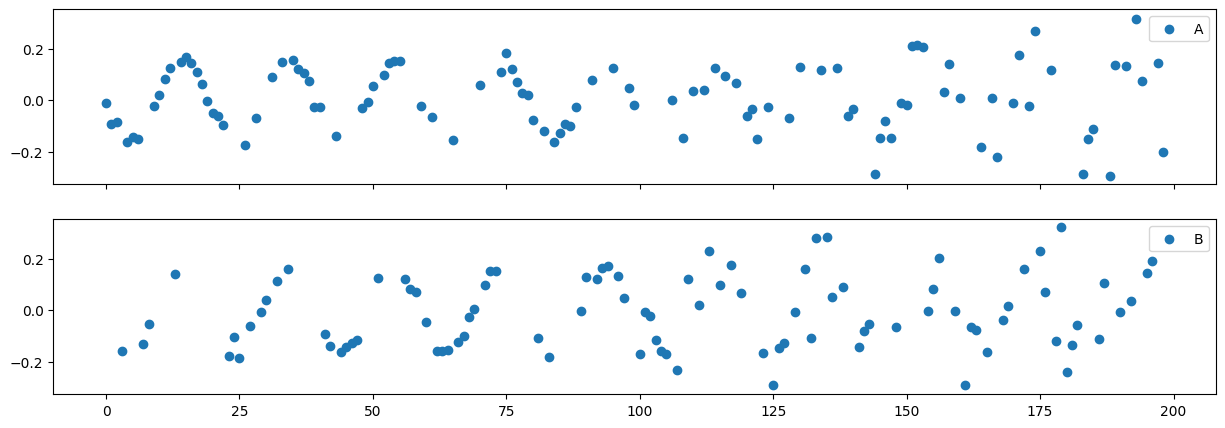

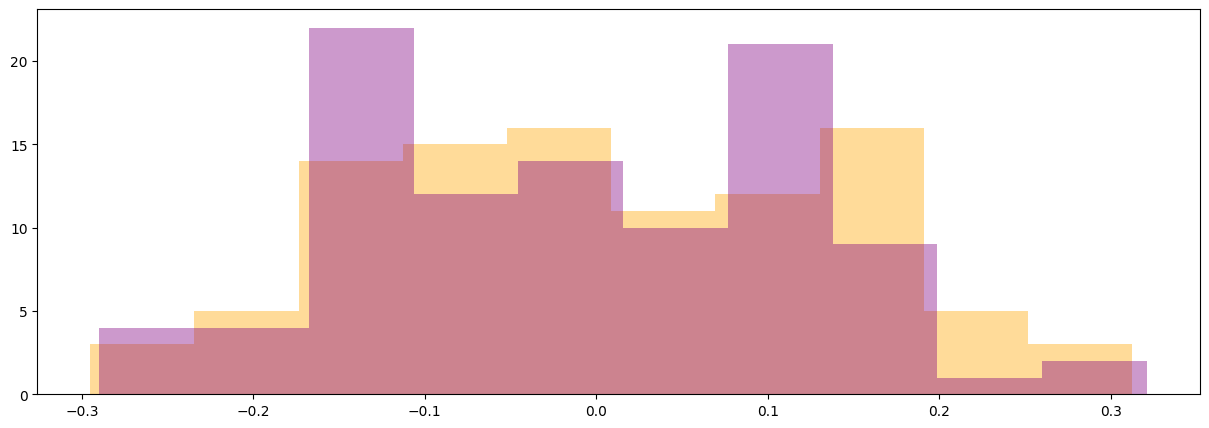

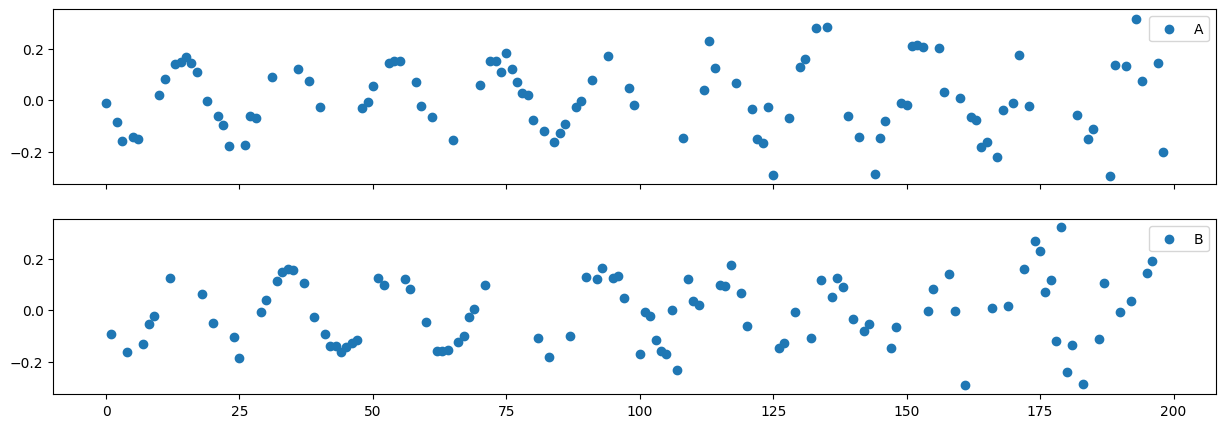

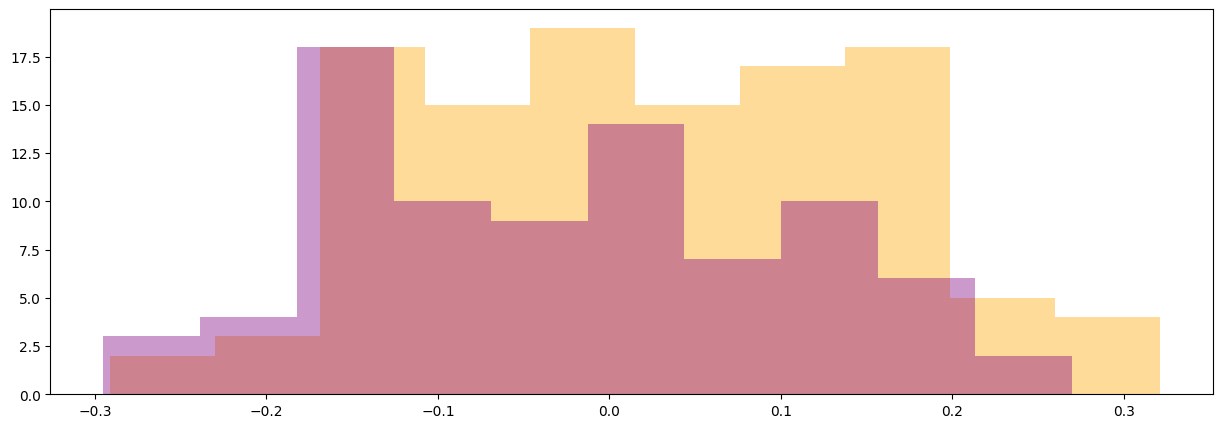

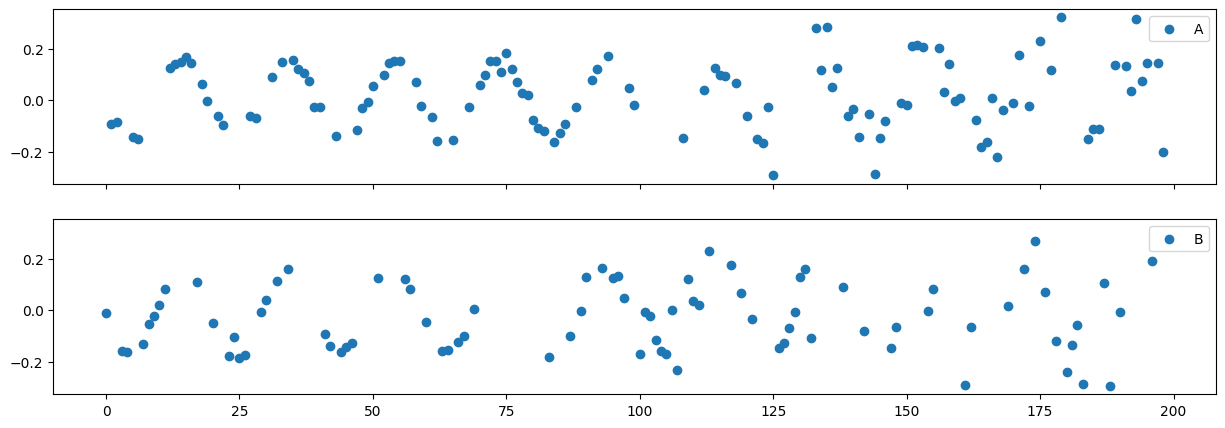

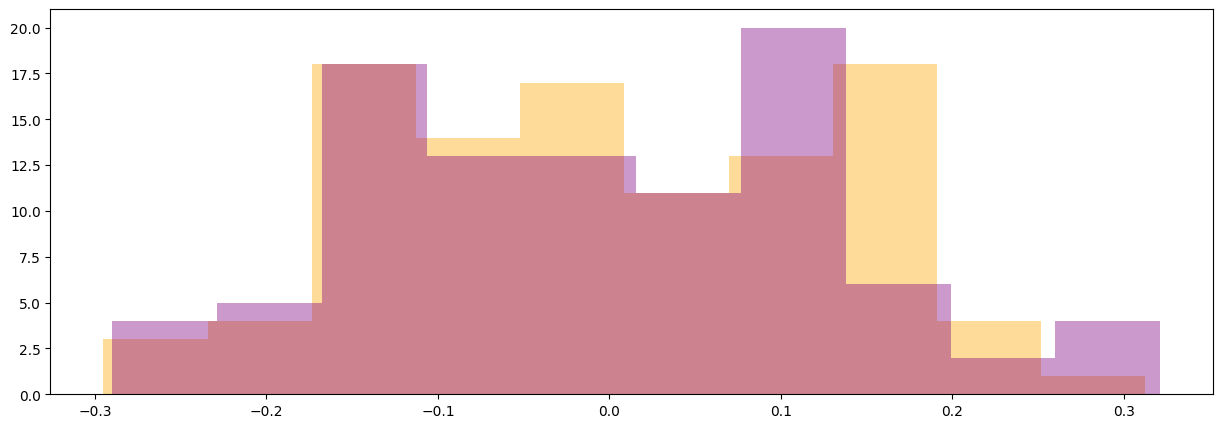

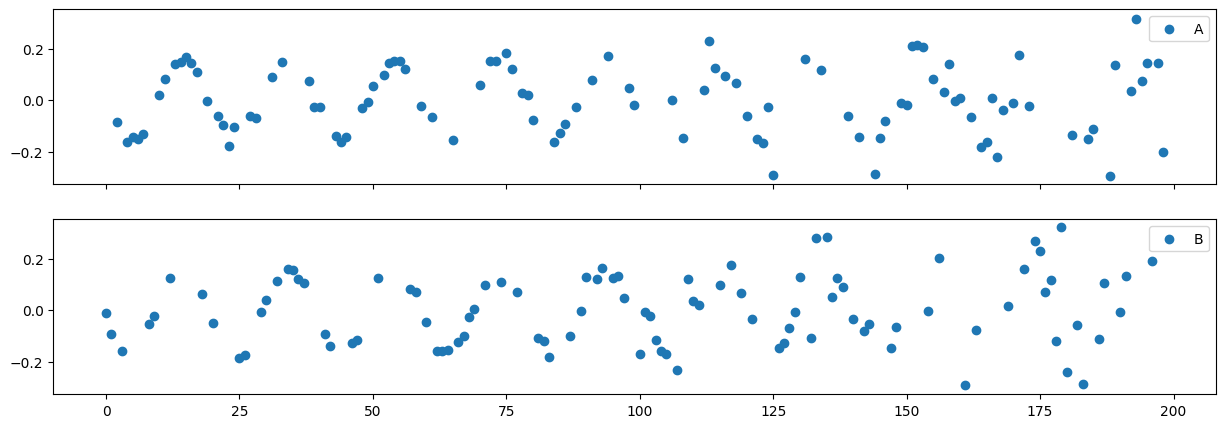

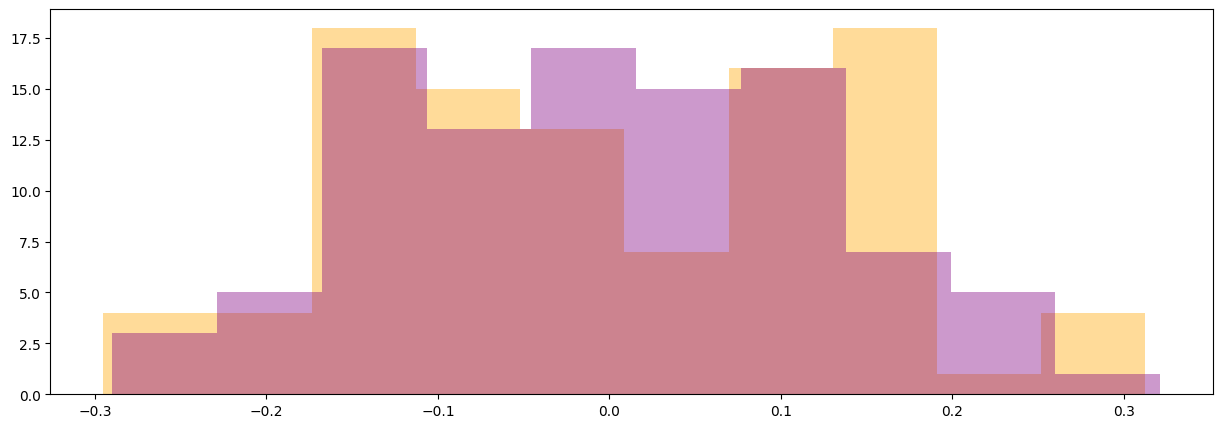

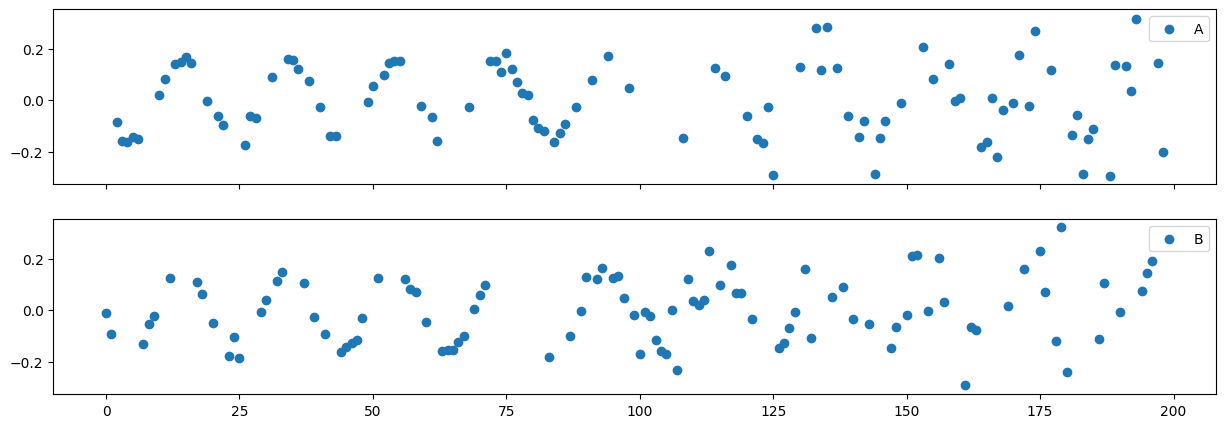

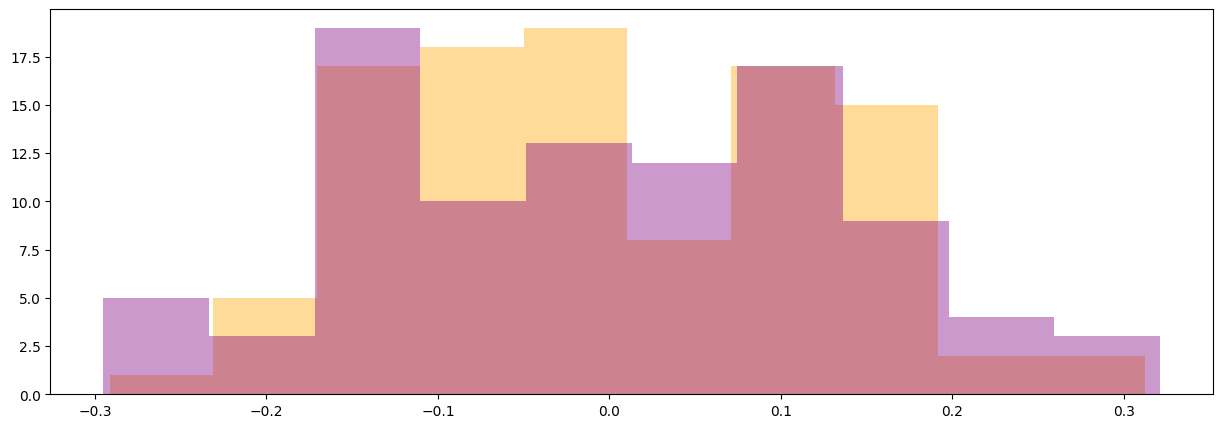

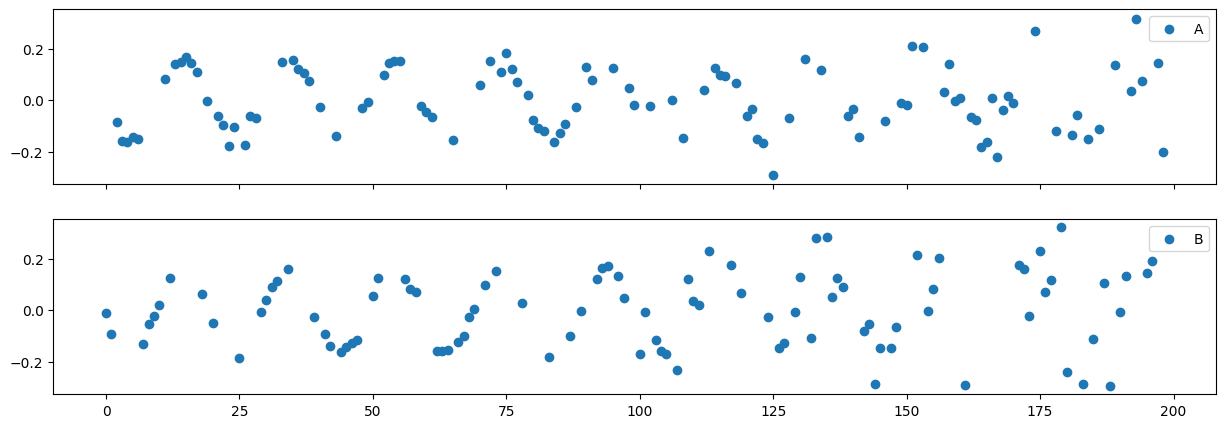

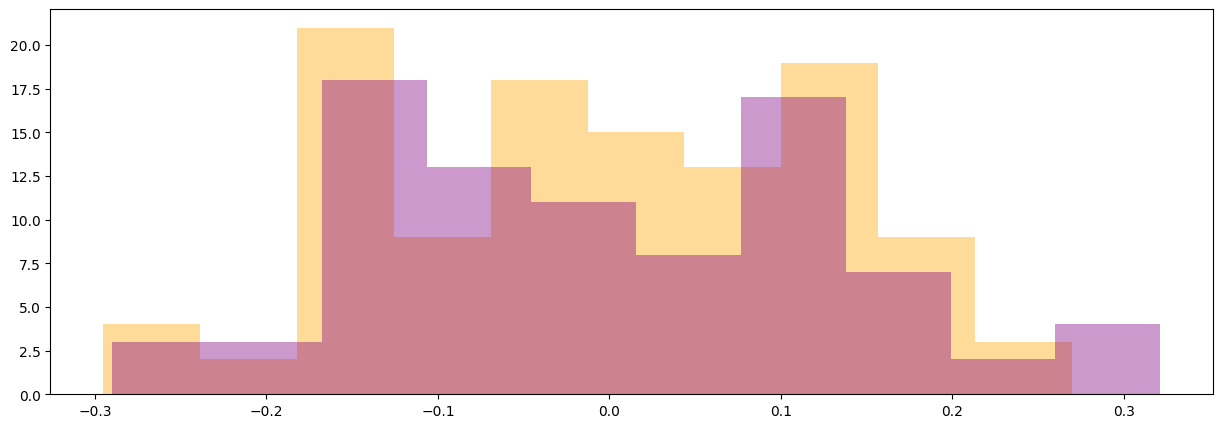

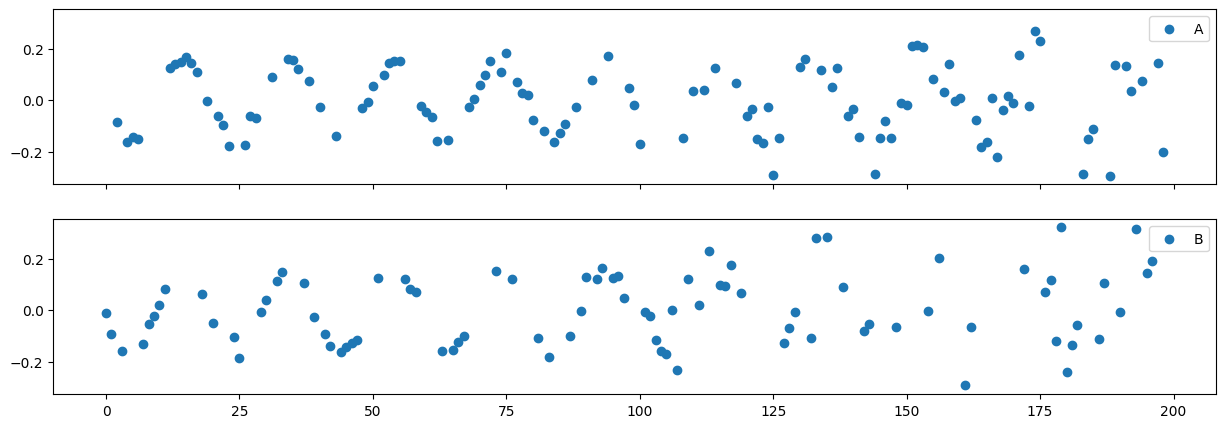

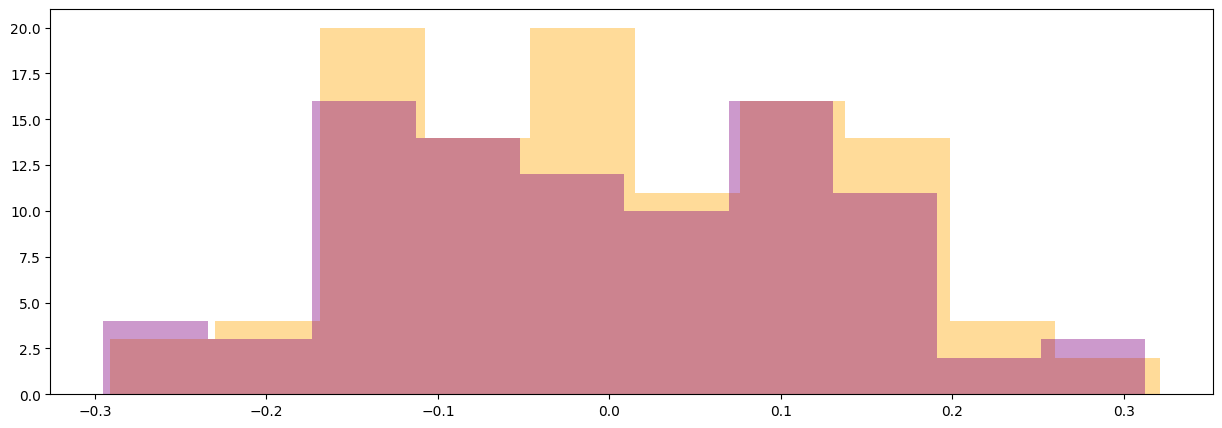

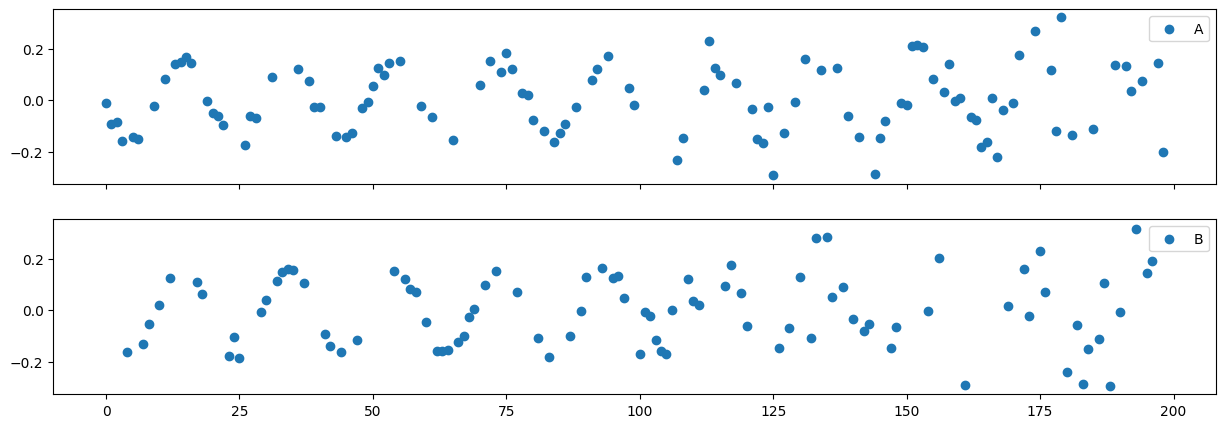

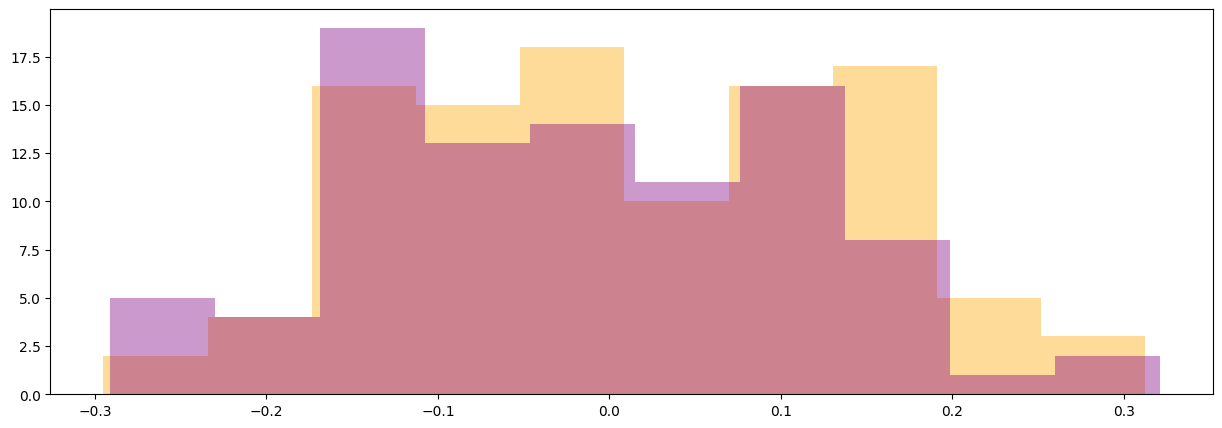

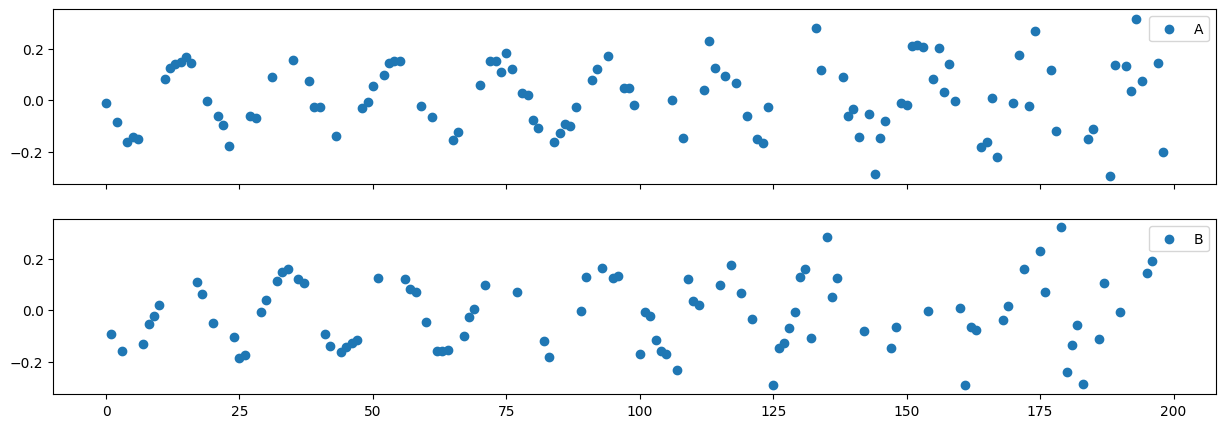

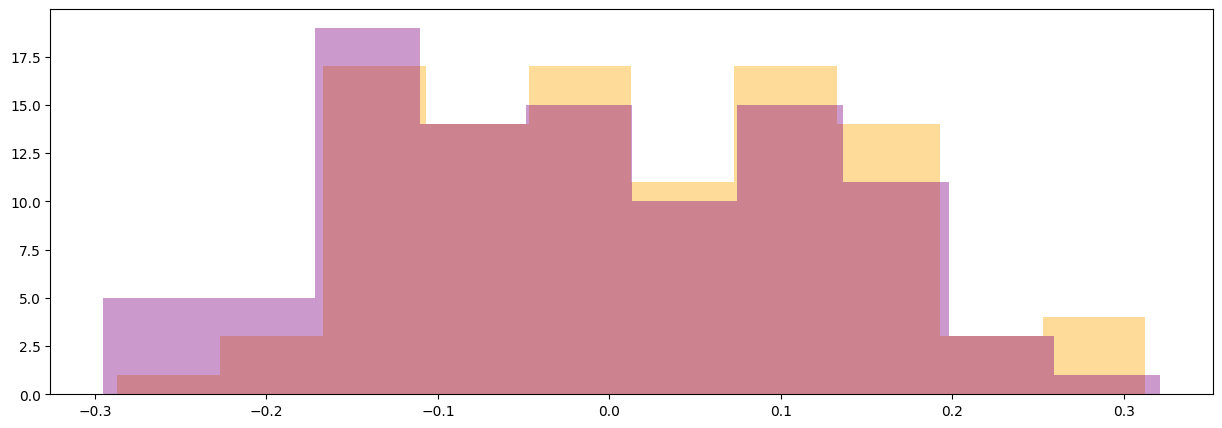

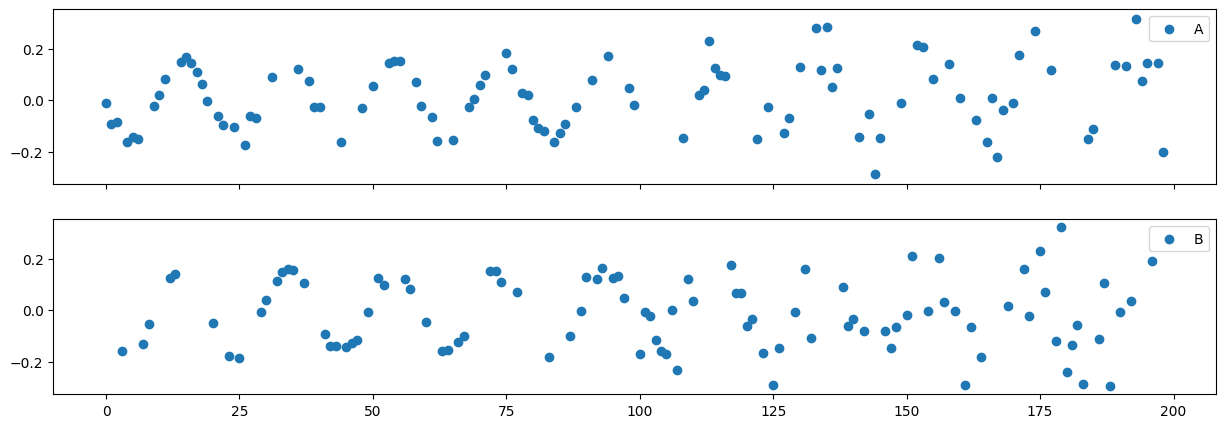

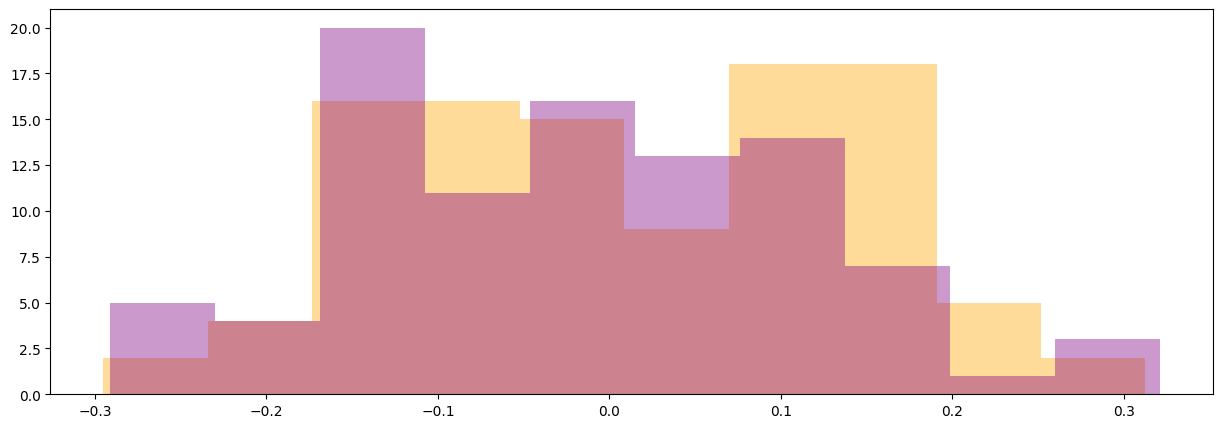

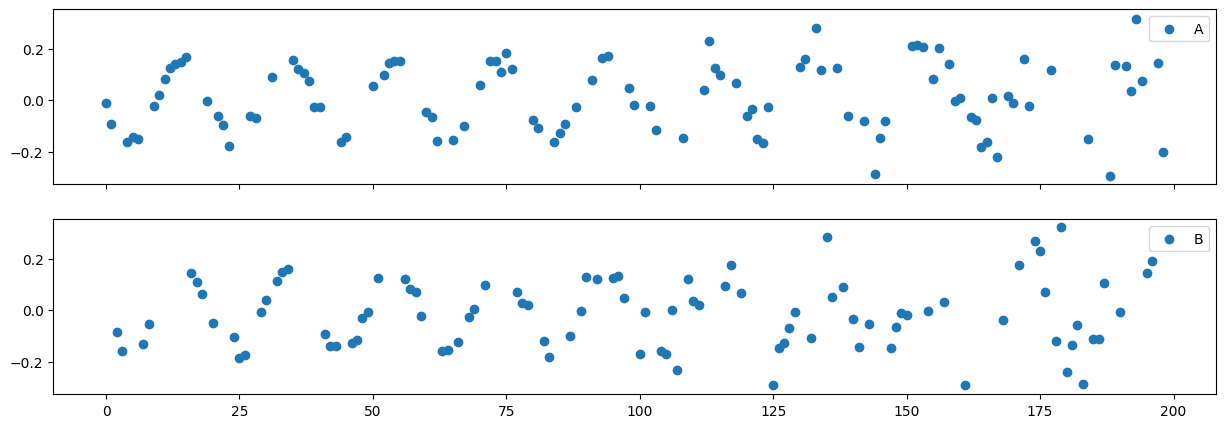

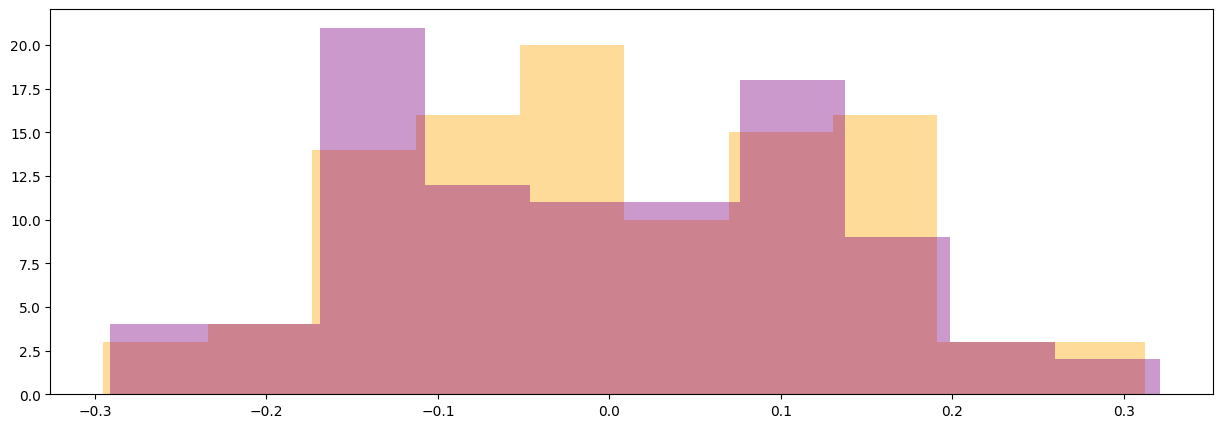

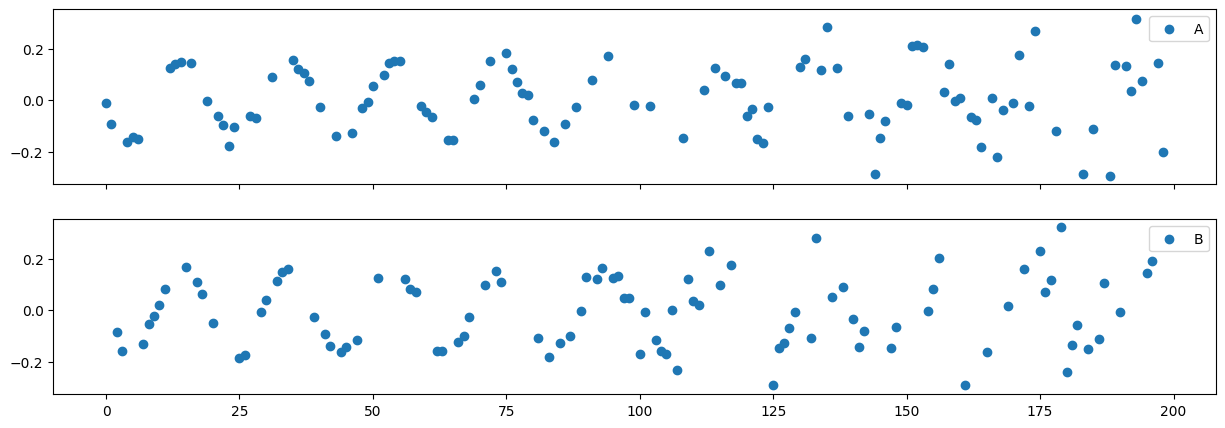

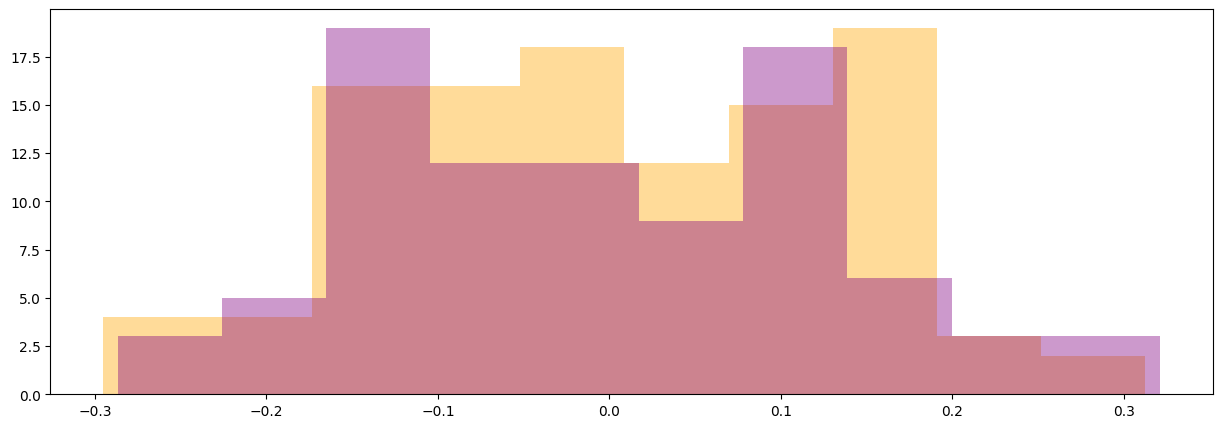

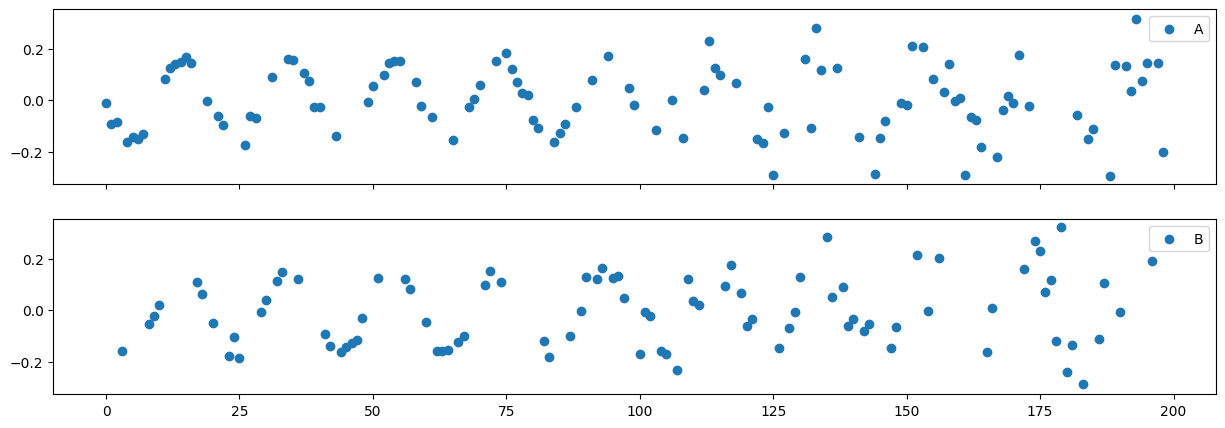

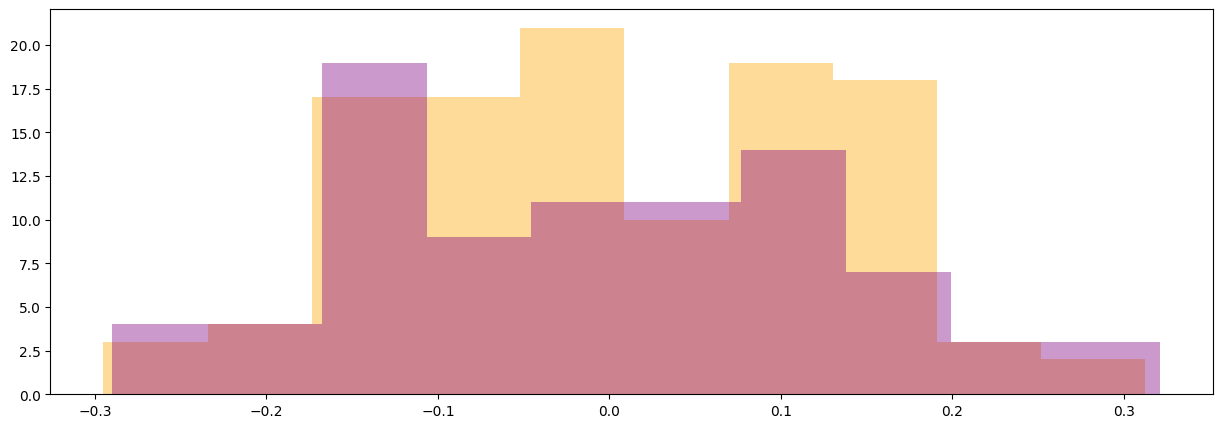

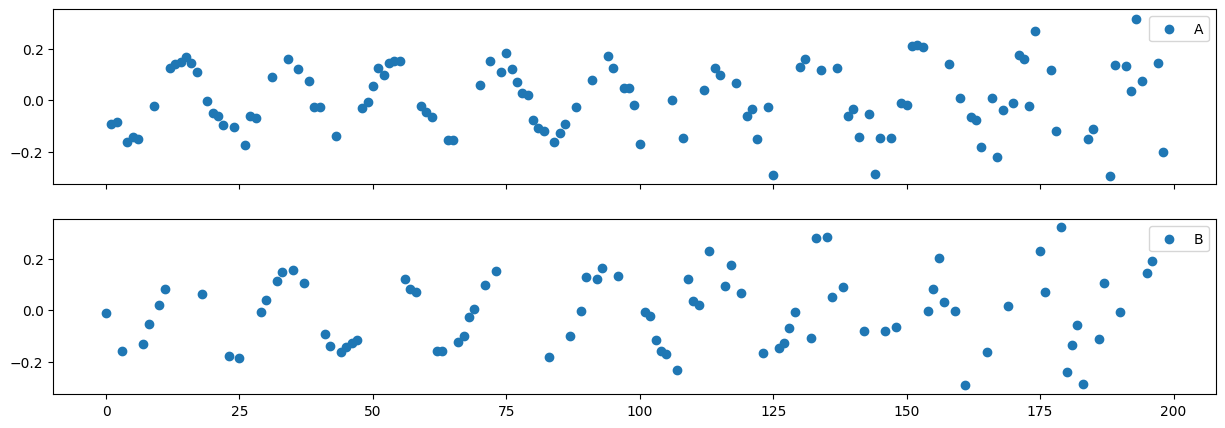

In [5]:
wave_tensor = torch.from_numpy(np.diff(noise_wave)).requires_grad_(True).float()
# wave_tensor = torch.tensor(wave_tensor, requires_grad=True).float()

plot_steps = 20
epochs = 100000

model = SineBinarySeparator(input_dim=wave_tensor.shape[0], dropout_p=.5).float()
for _ in range(plot_steps):
    model.train(wave_tensor, epochs=epochs)
    model.plot_loss()